Install dependencies for kaggle notebook

In [1]:
! apt update
! apt install -y python3-dev zlib1g-dev libjpeg-dev cmake swig python-pyglet python3-opengl libboost-all-dev libsdl2-dev libosmesa6-dev patchelf ffmpeg xvfb
! pip install git+https://github.com/openai/gym.git#egg=gym[box2d]
! pip install xvfbwrapper
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!apt-get install ffmpeg -y

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5386 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6751 B]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [256 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1155 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [1216 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2192 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [870 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [26.0 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-securit

Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from collections import deque
import gym

Class responsible for initializing the neural network

In [3]:
class NNetwork:
    def __init__(self, n_actions, state_size, learning_rate, filename_in = '../input/network/dqn', filename_out = 'dqn'):
        self.n_actions = n_actions
        self.state_size = state_size
        self.learning_rate = learning_rate
        self.filename_in = filename_in
        self.filename_out = filename_out
        self.model = 0

    def save_model(self):
        self.model.save(self.filename_out)

    def load_model(self):
        model = load_model(self.filename_in)
        return model

    def network_init(self, train):
        if train == True:
            # Create model with 2 fully connected layers (The third one acts as a classifier - each neuron calculates q value for the indexed action)
            self.model = Sequential([
                Dense(64, input_shape = (self.state_size, )),
                Activation('relu'),
                Dense(64),
                Activation('relu'),
                Dense(self.n_actions)])

            # Optimize with ADAM and with declated learning rate
            self.model.compile(optimizer=Adam(learning_rate = self.learning_rate),loss='mse')
        else:
            # Load previously trained model
            self.model = self.load_model()
            self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return self.model

Class responsible for memory handling - store experiences in the buffer

In [4]:
class ReplayBuffer:
    def __init__(self, possible_states, buffer_size):
        self.buffer_size = buffer_size
        # State in this case is declared by 8 values
        self.state_memory = np.zeros((self.buffer_size, possible_states)) 
        self.next_state_memory = np.zeros((self.buffer_size, possible_states))
        self.action_memory = np.zeros(self.buffer_size, dtype=np.int8)
        self.reward_memory = np.zeros(self.buffer_size)
        # Final reward, not integer
        self.dones_memory = np.zeros(self.buffer_size, dtype=np.float32) 
        self.buffer_counter = 0
    
    # Add the experiences to memory
    def add_to_buffer(self, state, action, reward, next_state, done):
        # Reset memory if full
        index = self.buffer_counter % self.buffer_size

        self.state_memory[index] = state
        self.next_state_memory[index] = next_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.dones_memory[index] = 1 - int(done)
        self.buffer_counter += 1

    # Load random set of experiences
    def load_sample_buffer(self, batch_size):
        # Create a list with a size of batch_size of random indexes from the buffer
        current_buffer_size = min(self.buffer_counter, self.buffer_size)
        rand_batch_index = np.random.choice(current_buffer_size, batch_size)

        states = self.state_memory[rand_batch_index]
        actions = self.action_memory[rand_batch_index]
        rewards = self.reward_memory[rand_batch_index]
        next_states = self.next_state_memory[rand_batch_index]
        done = self.dones_memory[rand_batch_index]

        return states, actions, rewards, next_states, done

Class responsible for the agent - acting and learning from experiences

In [5]:
class Agent:
    def __init__(self, n_actions, batch_size, state_dims,
                 learning_rate, discount_factor, buffer_size = int(1e5), train = True):
        
        self.possible_actions = [i for i in range(n_actions)]
        self.batch_size = batch_size
        self.buffer = ReplayBuffer(state_dims, buffer_size)
        self.discount_factor = discount_factor
        self.net = NNetwork(n_actions, state_dims, learning_rate)
        self.network = self.net.network_init(train)

    # Perform an action according to the epsilon value (take a random action or use the network to predict the best action for current state)
    def act(self, state, epsilon):
        state = np.expand_dims(state, axis=0) 
        rand_factor = np.random.random()
        if rand_factor < epsilon:
            # explore
            action = np.random.choice(self.possible_actions) 
        else:
            # exploit
            actions = self.network.predict(state) 
            # Take index of action with the biggest q
            action = np.argmax(actions) 
        return action
    
    # Function responsible for training the network
    def learn(self):
        # Start training only if the buffer is fully filled 
        if self.buffer.buffer_counter < self.batch_size:
            return
        else:
            batch_ind = np.arange(self.batch_size)
            # Load sample buffer
            state, action, reward, next_state, done = self.buffer.load_sample_buffer(self.batch_size) 
            q_current = self.network.predict(state)
            q_next = self.network.predict(next_state)
            q_target = q_current.copy()
            # Bellman equation
            q_target[batch_ind, action] = reward + self.discount_factor * np.max(q_next, axis = 1) * done
            # Fit the network to the target q calculated from the Bellman equation
            learn = self.network.fit(state, q_target, verbose=0)

    def to_buffer(self,state, action, reward, next_state, done):
        self.buffer.add_to_buffer(state, action, reward, next_state, done)

Function to initialize environment with specified parameters

In [6]:
def lunar_lander(train = True, n_episodes = 2000, max_t = 1000, batch_size=64, state_dims=8,
                learning_rate=0.001, discount_factor=0.99,
                epsilon=1.0, eps_decay=0.997, eps_final=0.01):
    # Setting up environment and training
    env = gym.make('LunarLander-v2')
    agent = Agent(n_actions=4, batch_size = batch_size, state_dims = state_dims,
                  learning_rate = learning_rate, discount_factor=discount_factor, train=train)

    # Start from specified epsilon and then decay by eps_decay value
    epsilon = epsilon
    scores = []
    epsilons = []
    avg_scores = []
    # Last 100 scores
    scores_window = deque(maxlen=100)  

    for i in range(n_episodes):
        # Start new game
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            # Accumulate score for the episode
            score += reward
            # Save to expieriences to memory
            agent.to_buffer(state, action, reward, next_state, int(done))
            state = next_state
            # Train the network
            agent.learn()
#             env.render() # This is only for visualising
            if done:
                break
        
        scores.append(score)
        scores_window.append(score)
        epsilons.append(epsilon)
        avg_score = np.mean(scores_window)
        avg_scores.append(avg_score)
        print(f'Episode: {i}, Score: {score}, Average Score: {avg_score}, Epsilon: {epsilon}')
        
        # Decay epsilon
        if epsilon != eps_final:
            epsilon = epsilon * eps_decay
        else:
            epsilon = eps_final

    # After training save model 
    agent.net.save_model()

    #Create plots of scores and epsilons
    fig, axs = plt.subplots(3)
    fig.suptitle('Performance plots of DQN')
    axs[0].plot(np.arange(len(scores)), scores)
    axs[0].set_ylabel('Score')
    axs[0].set_xlabel('Episode')
    axs[1].plot(np.arange(len(epsilons)),epsilons)
    axs[1].set_ylabel('Epsilon')
    axs[1].set_xlabel('Episode')
    axs[2].plot(np.arange(len(avg_scores)),avg_scores)
    axs[2].set_ylabel('Average Score')
    axs[2].set_xlabel('Episode')
    plt.show()
    fig.savefig('plots.png')

Initialize the training

2022-04-27 19:29:13.777107: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-27 19:29:14.276620: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Episode: 0, Score: 138.65009725787283, Average Score: 138.65009725787283, Epsilon: 0.2
Episode: 1, Score: 42.83015783525577, Average Score: 90.7401275465643, Epsilon: 0.19940000000000002
Episode: 2, Score: -247.16862125615285, Average Score: -21.89612205434142, Epsilon: 0.19880180000000003
Episode: 3, Score: 37.512674013414305, Average Score: -7.043923037402488, Epsilon: 0.19820539460000003
Episode: 4, Score: 158.67984069008915, Average Score: 26.10082970809584, Epsilon: 0.19761077841620003
Episode: 5, Score: -154.12819601731235, Average Score: -3.937341246138857, Epsilon: 0.19701794608095144
Episode: 6, Score: -243.40081133402708, Average Score: -38.14640840155146, Epsilon: 0.1964268922427086
Episode: 7, Score: -53.190684091543126, Average Score: -40.026942862800425, Epsilon: 0.19583761156598048
Episode: 8, Score: -212.26724041240004, Average Score: -59.16475370164483, Epsilon: 0.19525009873128255
Episode: 9, Score: -392.7790064428337, Average Score: -92.52617897576371, Epsilon: 0.194

2022-04-28 05:15:51.962974: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


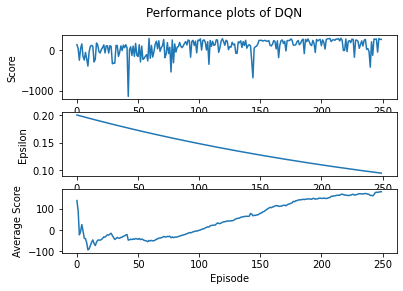

In [7]:
# This is the second part of the training which takes the dqn_First model and improves it
lunar_lander(train = False, n_episodes=250, epsilon = 0.2)